In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL

In [2]:
sineRegress = FuncRecursiveNet([
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(1, True)
    ])

In [3]:
kb_size = 10
train_size = 90

In [4]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])
print(shape_record)

#data = Dataset(dataset)
indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
#print(temp)
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
# val_indx = list(np.random.choice(temp, size=55, replace=False))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])



{0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}
10
90
44


In [5]:
print(dataset[0][0])
print(type(dataset[0][1]))
print(dataset[0][0], len(dataset[0][1]), len(dataset[0][2]), len(dataset[0][3]))

(0.4, 1, 0.0)
<class 'list'>
(0.4, 1, 0.0) 6 200 200


In [6]:
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=15, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 3]) torch.Size([10, 1, 1761]) torch.Size([10, 200, 1]) torch.Size([10, 200, 1])


tensor([0.8000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.875pi, pred loss=0.0


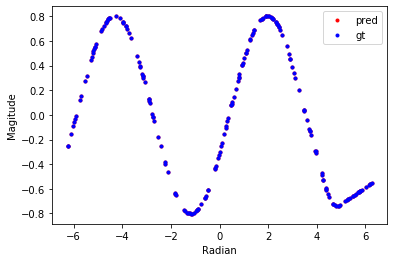

In [7]:
#test visualization and rehspae uitls
item = [support_a[0,:].float(), support_w[0,:].float(), support_x[0,:].float(), support_y[0,:].float()]
utils.taskVisualize(item, sineRegress, shape_record)

In [8]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
print(support_a.size())
dm = support_a.size()[0]

param_dict = {}
param_dict['rho'] = 0.0005
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, sineRegress, param_dict)

torch.Size([3, 10])


 m train metric 0.31260552996148666; m test metric 0.39203626361929556; align loss  0.001530562760308385
600/2000 o_loss 0.6226028891901175; m train metric 0.3536176845431328; m test metric 0.4156028287993236; align loss  0.0014184709871187806
610/2000 o_loss 0.4731611520051956; m train metric 0.294388884305954; m test metric 0.33160980939018453; align loss  0.0014323950745165348
620/2000 o_loss 0.4597269458075364; m train metric 0.26449015984932583; m test metric 0.3224878120236099; align loss  0.0013713703956454992
630/2000 o_loss 0.5098604907592137; m train metric 0.347311902542909; m test metric 0.28247006512670353; align loss  0.0013224480208009481
640/2000 o_loss 0.45676827505230905; m train metric 0.2720639551679293; m test metric 0.3228391277688471; align loss  0.0013381039025261998
650/2000 o_loss 0.364514239753286; m train metric 0.16655425733576218; m test metric 0.3439291557720439; align loss  0.0013763174647465348
660/2000 o_loss 0.4956495240330696; m train metric 0.275218

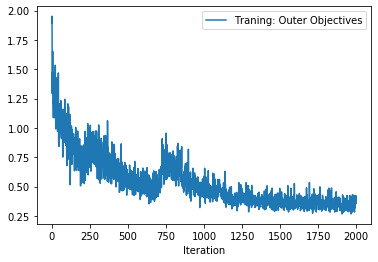

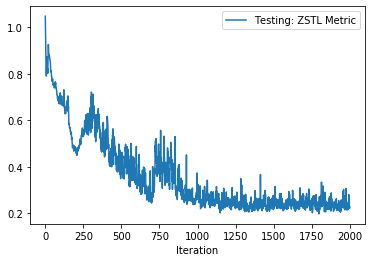

0

In [9]:
ZSTL_model.train(train_loader, test_loader, max_iter=2000)

tensor([0.8000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.5pi, pred loss=0.07346590608358383


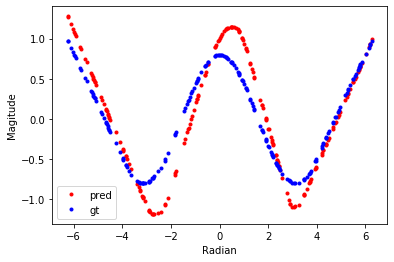

tensor([1.6000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.625pi, pred loss=0.2296578735113144


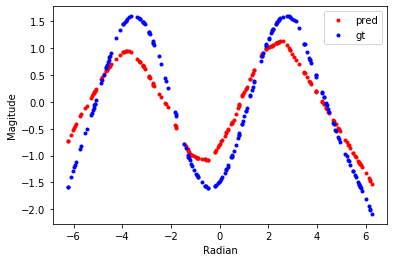

tensor([1.0000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.75pi, pred loss=0.02587515488266945


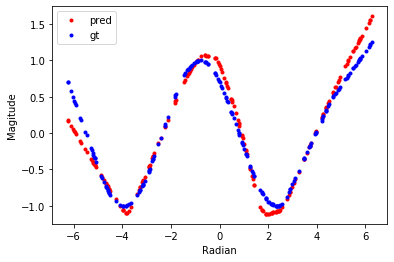

tensor([0.4000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.375pi, pred loss=0.19496114552021027


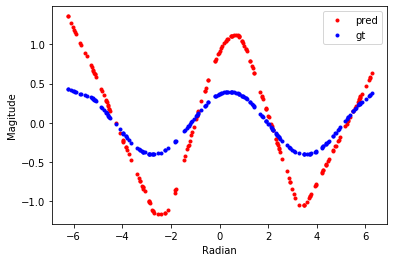

tensor([1.2000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.5pi, pred loss=0.07647641748189926


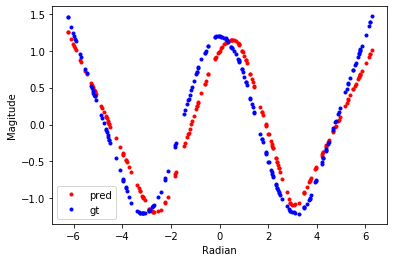

tensor([1.4000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.5pi, pred loss=0.3702179789543152


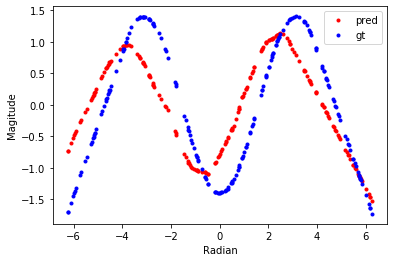

tensor([1.2000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.027633998543024063


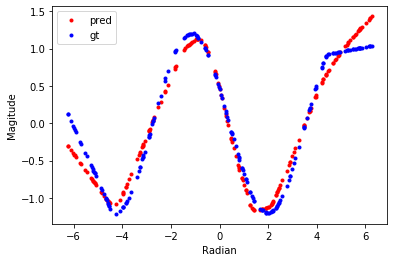

tensor([1.0000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.625pi, pred loss=0.04927423596382141


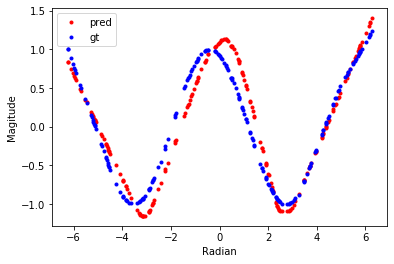

tensor([1.6000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.75pi, pred loss=0.16358385980129242


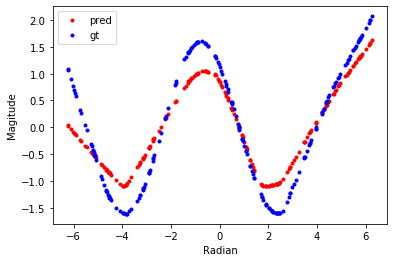

tensor([2.0000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.5pi, pred loss=0.892362117767334


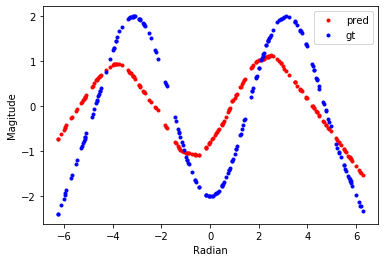

tensor([0.4000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.22623567283153534


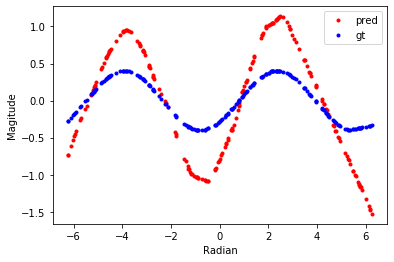

tensor([0.6000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.0pi, pred loss=0.15922081470489502


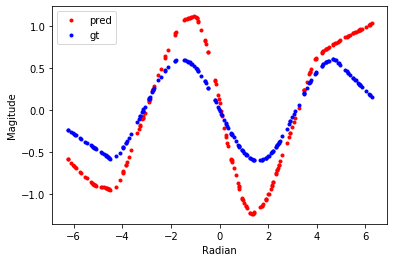

tensor([0.6000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.625pi, pred loss=0.1348409801721573


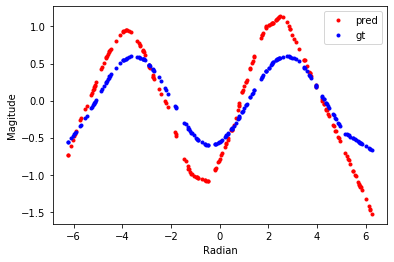

tensor([0.4000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.5pi, pred loss=0.23109287023544312


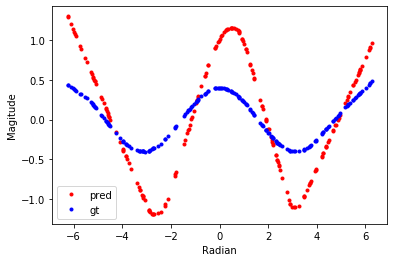

tensor([1.6000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.5058029890060425


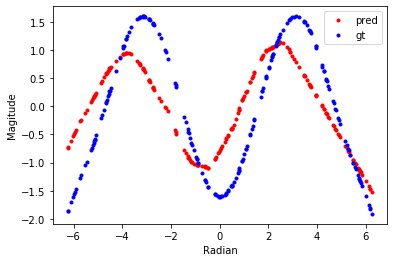

tensor([0.6000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.125pi, pred loss=0.08393813669681549


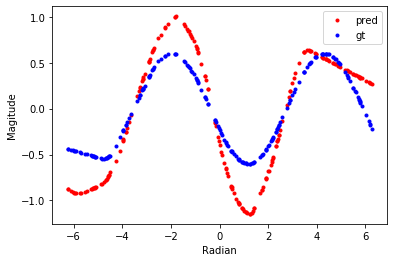

tensor([0.4000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.75pi, pred loss=0.2693651616573334


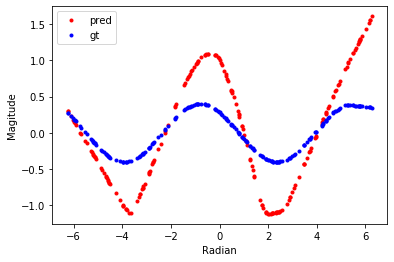

tensor([0.4000, 1.0000, 0.0000])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.0pi, pred loss=0.2873745560646057


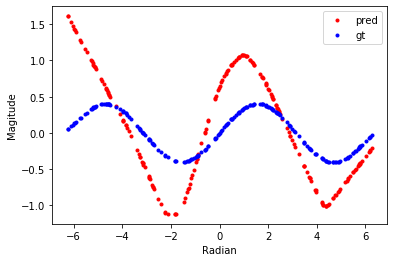

tensor([1.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.125pi, pred loss=0.14210475981235504


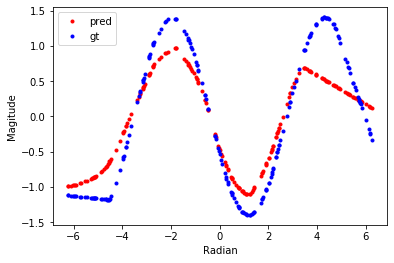

tensor([1.6000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.11439963430166245


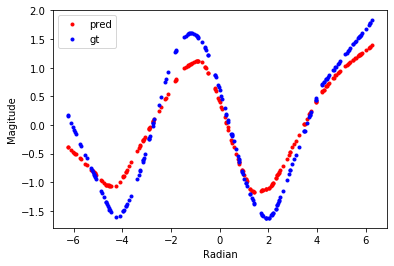

tensor([2.0000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.5pi, pred loss=0.5650020837783813


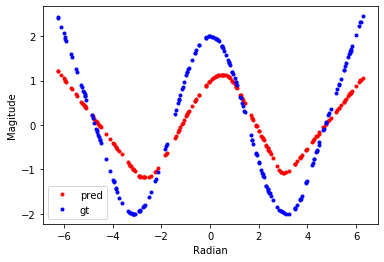

tensor([1.2000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.625pi, pred loss=0.06855235248804092


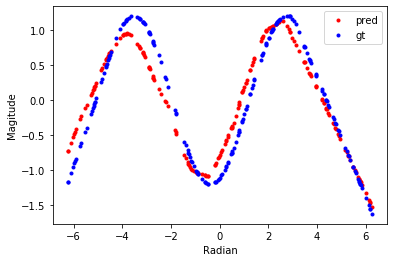

tensor([0.6000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.5pi, pred loss=0.13244536519050598


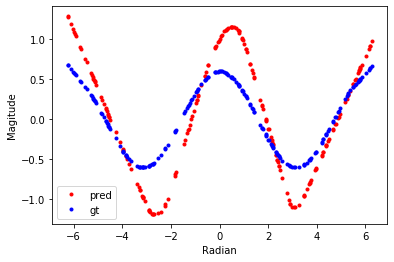

tensor([1.4000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.25pi, pred loss=0.19416294991970062


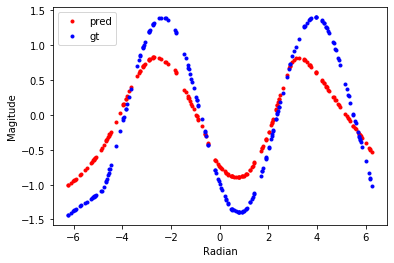

tensor([0.6000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.875pi, pred loss=0.18799328804016113


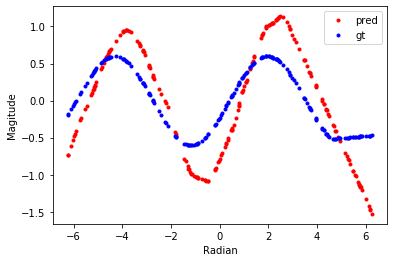

tensor([0.4000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.25pi, pred loss=0.19682906568050385


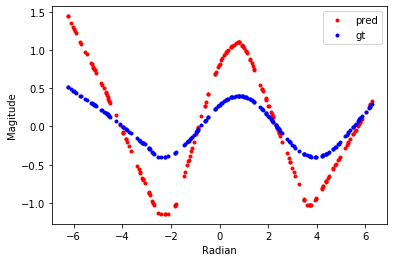

tensor([0.6000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.045203980058431625


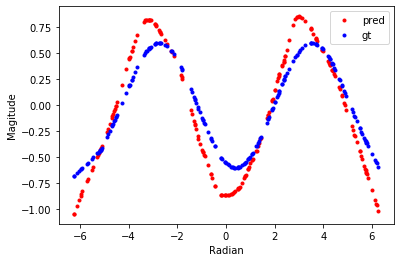

tensor([2.0000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.125pi, pred loss=0.5105835199356079


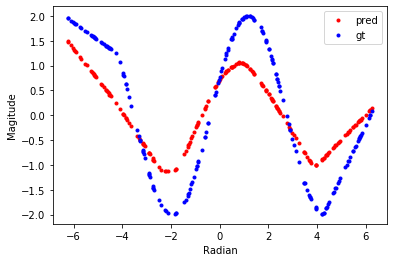

tensor([2.0000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.875pi, pred loss=0.6121400594711304


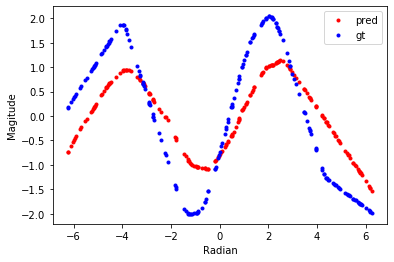

tensor([0.8000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.030597012490034103


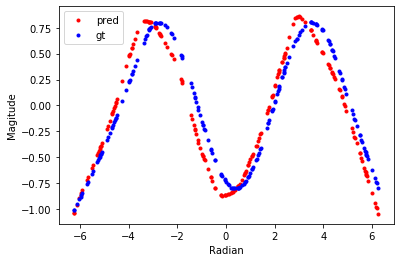

tensor([1.4000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.625pi, pred loss=0.10051652044057846


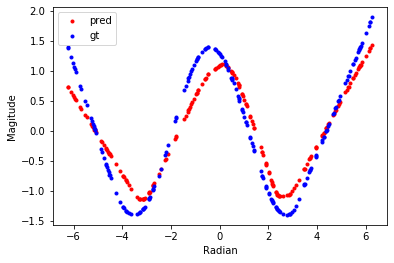

tensor([1.4000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.060237541794776917


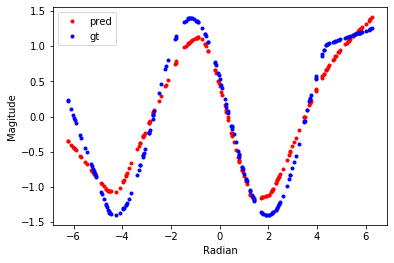

tensor([1.4000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.0pi, pred loss=0.06935084611177444


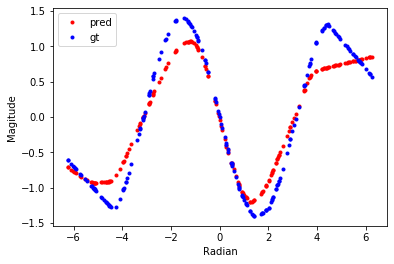

tensor([1.2000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.5pi, pred loss=0.26408132910728455


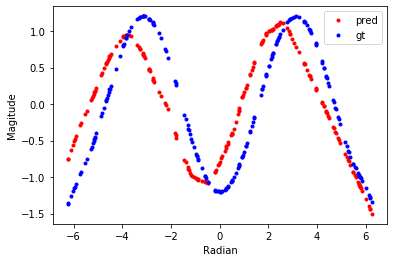

tensor([0.6000, 1.0000, 0.0000])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.0pi, pred loss=0.20800675451755524


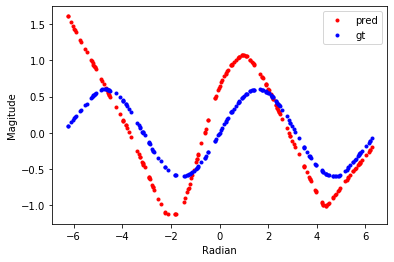

tensor([2.0000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.450080931186676


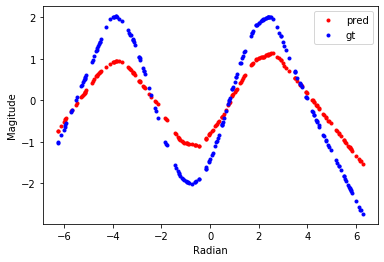

tensor([0.8000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.0455193854868412


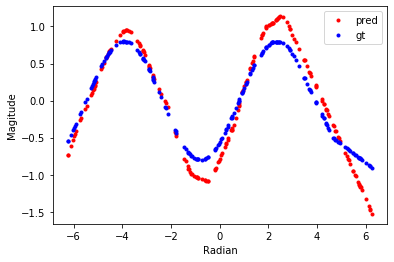

tensor([2.0000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.0pi, pred loss=0.37916967272758484


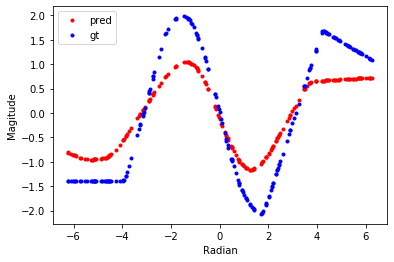

tensor([1.0000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.5pi, pred loss=0.05528922751545906


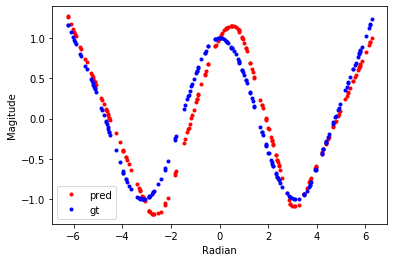

tensor([2.0000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.625pi, pred loss=0.5509361624717712


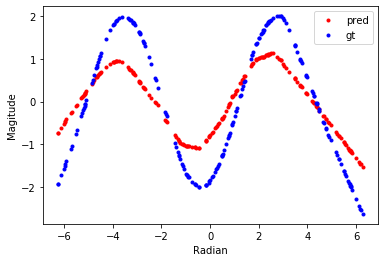

tensor([1.2000, 1.0000, 0.0000])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.0pi, pred loss=0.14941737055778503


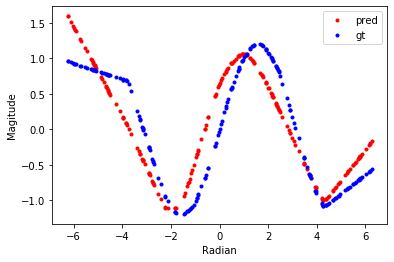

tensor([1.8000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.6311612725257874


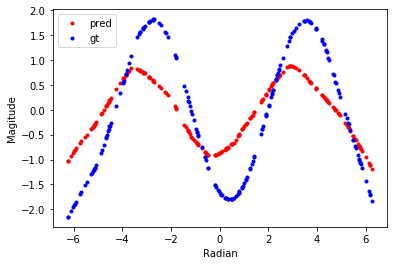

tensor([1.2000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.875pi, pred loss=0.16203653812408447


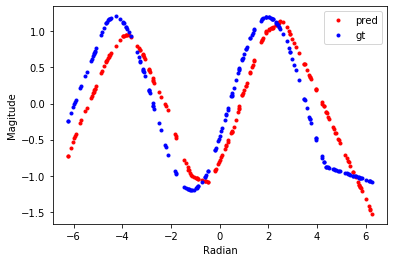

tensor([0.6000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.375pi, pred loss=0.09624841809272766


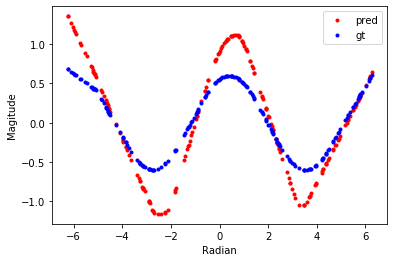

In [10]:
test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

test_w_pred = ZSTL_model.task_transfer(test_a, ZSTL_model.a_kb_opt)
test_batch_size = test_w_pred.size()[1]
tt_w = test_w_pred.clone().detach()


for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  utils.taskVisualize(item, sineRegress, shape_record)